# Multi-Output Image Classification

## Project Goal
To develop a multi-output image classifier.

## Dataset
https://www.kaggle.com/kwentar/blur-dataset

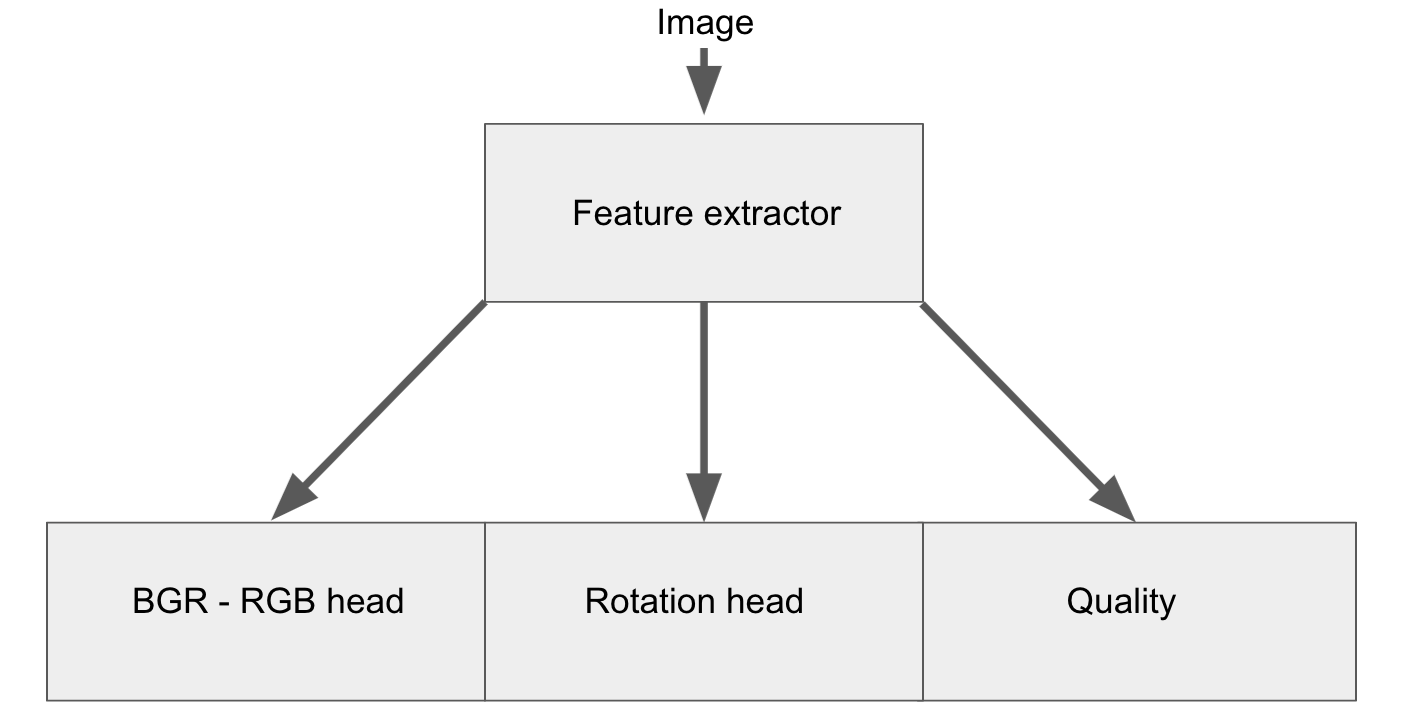

## Project Methodology

As an input, the model takes an image; as an output, there should be probabilities calculated for the next classes:

### Output - *quality*: 

**classes**: 

1. Blur - *image is blurred*

2. Torch -  *image is overexposed*

3. Sharp - *image is sharp and clean*

### Output - *rotation*:

**classes**: 

1. No rotation 0 degrees.

2. Сlockwise rotation for 90 degrees.

3. Counterclockwise rotation for 90 degrees.

4. Flipped image for 180 degrees.


### Output  RGB-BGR:

**classes**:

1. RGB

2. BGR

## Tips to mention

1. Write your own solution, do not use prettrained ones.
2. Use some of the Python libraries which you are most comfortable with - Pytorch, FastAI, Keras, Tensorflow.


## 1 Data load

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()  # Choose the kaggle.json file that you downloaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinavyadav27","key":"a40a65e42ed5139b5e7e3d6e4e32416b"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/  # Make directory named kaggle and copy kaggle.json file there.
! chmod 600 ~/.kaggle/kaggle.json # Change the permissions of the file.
! kaggle datasets list

ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51          10202        340  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           8609        204  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:26:03            815         45  1.0              
anas123siddiqui/mobiles                                    Mobiles                                      59KB  2023-02-18 16:3

In [3]:
# Download the dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

100% 1.49G/1.49G [00:51<00:00, 39.9MB/s]
100% 1.49G/1.49G [00:51<00:00, 31.1MB/s]


In [4]:
# imports

import cv2
import os
import imutils
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Input, Multiply, Activation, concatenate
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau

## 2  Data Preparation

In [5]:
ROOT_PATH = '/content/'
IMG_SIZE = 96

In [6]:
# Data Preparation

dataset_dir = '/content/'
categories = ['defocused_blurred', 'motion_blurred','sharp']
training_bgr = []
training_rgb = []

# saving data with respect to RGB and BGR
def create_training_data():
    for i in range(0,2,1):
        print(i)
        for category in categories:
            path = dataset_dir+category
            print(path)
            class_num = categories.index(category)
            
            for img in os.listdir(path):
                if i == 0:
                  img_array = cv2.imread(os.path.join(path, img))
                  img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                  training_bgr.append([img_array, class_num])
                if i==1:
                  img_array = cv2.imread(os.path.join(path, img))
                  img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                  img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                  training_rgb.append([img_array, class_num])
                  
        i+=1
                    
create_training_data()

0
/content/defocused_blurred
/content/motion_blurred
/content/sharp
1
/content/defocused_blurred
/content/motion_blurred
/content/sharp


In [7]:
# Data Preprocessing

def preprocessing(training, n):
    # shuffling the dataset
    random.shuffle(training)

    # assigning labels and features

    X = []
    y = []
    for features, label in training:
        X.append(features)
        y.append(label)

    # resizing features in accordance with CNN
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    # Normalising X and converting labels to categorical features
    X = X.astype('float32')
    X /= 255

    y = np_utils.to_categorical(y,n)

    # splitting X and y for use in CNN
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    
    return X_train, X_test, y_train, y_test

Each aforementioned class has three types of data with the class labels,  thus data for each of the three classes has the following images:
* Original Images from the link
* Rotated Images
* BGR and RGB Images

### Rotation

In [8]:
angles = [0, 270, 90, 180] # (0 degree, 90 degree clockwise, 90 degree anticlockwise, 180 degree or flipped image)

def rotate(image, angle):
    image = imutils.rotate(image, angle=angle) # this rotates image in anti-clockwise direction
    return image

training_rotate = []

for i in range(len(training_rgb)):
    for angle in angles:
        class_num = angles.index(angle)
        training_rgb[i][0] = rotate(training_rgb[i][0], angle)
        training_rotate.append([training_rgb[i][0], class_num]) 

for i in range(len(training_bgr)):
    for angle in angles:
        class_num = angles.index(angle)
        training_bgr[i][0] = rotate(training_bgr[i][0], angle)
        training_rotate.append([training_bgr[i][0], class_num])  

X_train_rotate, X_test_rotate, y_train_rotate, y_test_rotate = preprocessing(training_rotate, len(angles))
len(training_rotate)

8400

### Quality

In [9]:
training_quality = []

for i in range(len(training_rgb)):
    for angle in angles:
        training_rgb[i][0] = rotate(training_rgb[i][0], angle)
        training_quality.append([training_rgb[i][0], training_rgb[i][1]]) 
        
for i in range(len(training_bgr)):
    for angle in angles:
        training_bgr[i][0] = rotate(training_bgr[i][0], angle)
        training_quality.append([training_bgr[i][0], training_bgr[i][1]])  
         

X_train_quality, X_test_quality, y_train_quality, y_test_quality = preprocessing(training_quality, len(categories))
len(training_quality)

8400

### Mode

In [10]:
mode = ['RGB', 'BGR']
training_mode = []

for i in range(len(training_rgb)):
    for angle in angles:
        training_rgb[i][0] = rotate(training_rgb[i][0], angle)
        training_mode.append([training_rgb[i][0], mode.index('RGB')])
        
for i in range(len(training_bgr)):
    for angle in angles:
        training_bgr[i][0] = rotate(training_bgr[i][0], angle)
        training_mode.append([training_bgr[i][0], mode.index('BGR')])  

X_train_mode, X_test_mode, y_train_mode, y_test_mode = preprocessing(training_mode, len(mode))
len(training_mode)

8400

## 3 Model

- Contruct and train the model (CNN, Transformers, SE blocks).
- Evaluate the model by any available quality metrics and confusion matrix.
- Visualize the model.
- Test the model on a test data.

### 2.3 Model - SE blocks

In [11]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

A **Squeeze and Excitation(SE)** block consists of two operations: 
* A squeeze operation and an excitation operation. The squeeze operation is a global pooling operation that reduces the spatial dimensions of the feature maps produced by the previous convolutional layer to a single channel. 
* The excitation operation then applies a set of fully connected layers to this single-channel representation, which produces a set of weights that are applied to the original feature maps to emphasize or suppress specific channels.

In [12]:
def SE_block(inputs, ratio=8):
    b, h, w, c = inputs.shape
    # squeeze 
    x = GlobalAveragePooling2D()(inputs)
    x = Reshape((1, 1, c))(x)
    # extraction
    x = Dense(c//ratio, activation='relu', kernel_initializer='glorot_uniform', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', kernel_initializer='glorot_uniform', use_bias=False)(x)

    # scaling
    x = Multiply()([inputs, x]) # x*inputs

    return x

# its returns tensor with original input shape

inputs = Input(shape=(128, 128, 32))
print(SE_block(inputs).shape)

def create_model(name):

    input_tensor = Input(shape=[IMG_SIZE, IMG_SIZE, 3], name=name)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SE_block(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # fully connected
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_tensor = Dense(9, activation='relu')(x)
    model = Model(inputs=[input_tensor], outputs=[output_tensor])
    
    return model

# fittin the model
# borrowed from Yulia

model_quality = create_model('class1')
model_rotate = create_model('class2')
model_mode = create_model('class3')

# segregating out ouput layers for three different classes
mergedOutput = concatenate([model_quality.output, model_rotate.output, model_mode.output])
out_quality = Dense(3, activation='softmax', name='quality')(mergedOutput)
out_rotate = Dense(4, activation='softmax', name='rotate')(mergedOutput)
out_mode = Dense(2, activation='softmax', name='mode')(mergedOutput)

merged_model = Model(inputs=[model_quality.input, model_rotate.input, model_mode.input],
                     outputs=[out_quality, out_rotate, out_mode])

print(merged_model.summary())

merged_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics="categorical_accuracy") 

history = merged_model.fit(x={'class1': X_train_quality, 'class2': X_train_rotate, 'class3': X_train_mode}, 
                           y={'quality': y_train_quality, 'rotate': y_train_rotate, 'mode': y_train_mode},
                           batch_size=64, epochs=25, callbacks=[learning_rate_reduction])

(None, 128, 128, 32)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 class1 (InputLayer)            [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 class2 (InputLayer)            [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 class3 (InputLayer)            [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 32)   896         ['class1[0][0]']                 
                                                                       

In [13]:
# saving the model

# serialize model to JSON
model_json = merged_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
merged_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model

'''json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")'''

In [14]:
# Metrics and Plotting

def model_metrics(y_test, y_pred, name):
  print(f'__{name}__')

  # compute the confusion matrix
  confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
  # plot the confusion matrix
  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()


def plot(history):

  plt.figure(figsize=(12,10))
  plt.subplot(1,2,1) 
  plt.plot(history.history['quality_loss'], color='b', label='Quality Loss')
  plt.plot(history.history['rotate_loss'], color='r', label='Rotate Loss')
  plt.plot(history.history['mode_loss'], color='k', label='Mode Loss')
  plt.title("Training Loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1,2,2) 
  plt.plot(history.history['quality_categorical_accuracy'], color='b', label='Quality Accuracy')
  plt.plot(history.history['rotate_categorical_accuracy'], color='r', label='Rotate Accuracy')
  plt.plot(history.history['mode_categorical_accuracy'], color='r', label='Mode Accuracy')
  plt.title("Training Accuracy")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

53/53 [==============================] - 2s 16ms/step
__Quality__


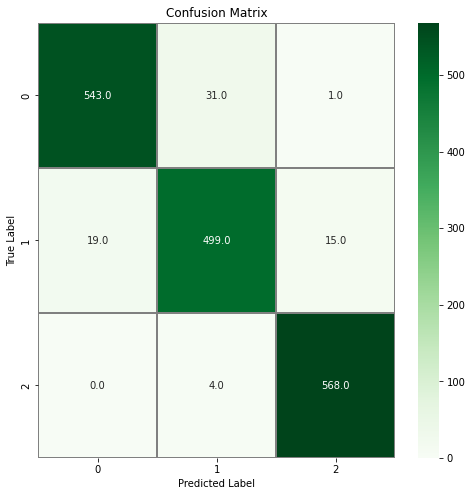

__Rotate__


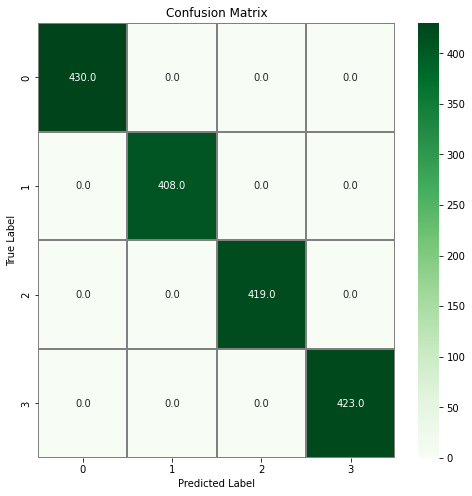

__Mode__


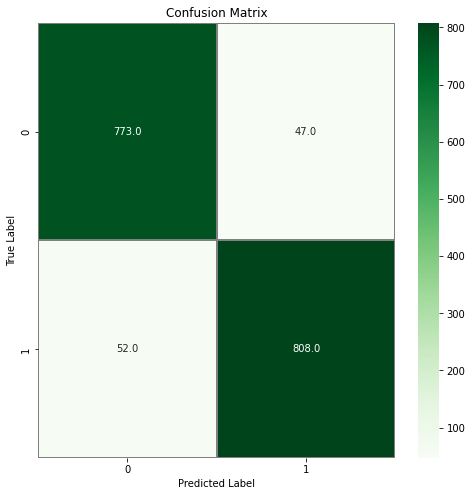

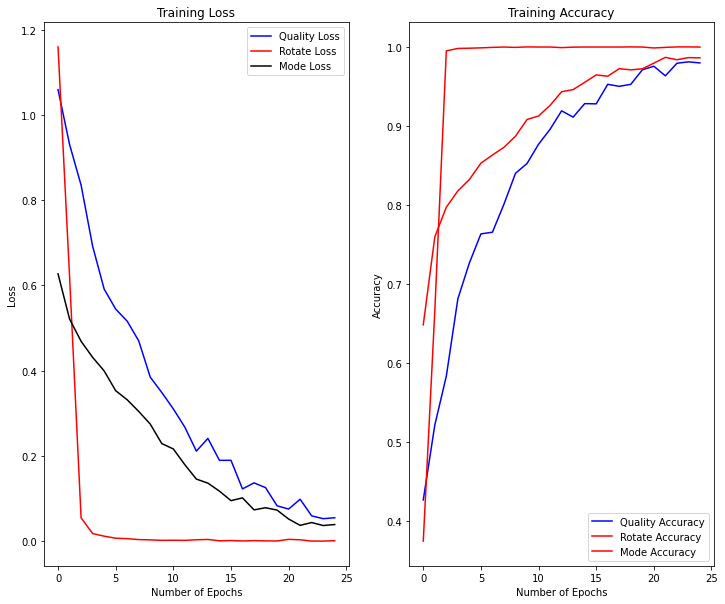

In [15]:
# predictions and metrics

predictions = merged_model.predict([X_test_quality, X_test_rotate, X_test_mode])

# quality
model_metrics(y_test_quality, predictions[0], 'Quality')

# rotate
model_metrics(y_test_rotate, predictions[1],'Rotate')

# mode
model_metrics(y_test_mode, predictions[2], 'Mode')

# plotting

plot(history)


### Conclusions

* Accuracy regarding Quality,Mode and Rotation is above 95% and nearing 100% since we are using SE blocks, which extracts information from each of the 3 channels.
* SE blocks are a sure way to go ahead with our clasification problem.

## Deadline - February 21st EOD
















































